# Studying CNN architectures with the dogs vs. cats dataset

Kaggle: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
# Packages which are not installed in the SageMaker TF2 kernel
!pip install matplotlib --quiet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

### tf2.x
import tensorflow as tf
from tensorflow import keras

### Data prep
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

### Model evaluation
from sklearn.metrics import classification_report

In [3]:
# Global random state
np.random.seed(42)
tf.random.set_seed(42)

# Some common variables
PATH_CHECKPOINT = '/root/Keras CNN - dogs vs. cats/checkpoints'
root_logdir ='s3://tensor.board/cats_and_dogs/logs'

In [4]:
# Custom functions
def reset_keras():
    keras.backend.clear_session()
    
def get_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

## EDA

<hr>
The dogs vs. cats dataset contains 12500 cat images and 12500 dog images. The two classes are perfectly balanced. However, images do not have a fixed size (i.e., dimensions), which needs preprocessing. To split the laballed images into training set and validaiton set, I have moved the files into the following directory structure:

<pre>
--train
  --cat  (10000 cat images)
  --dog  (10000 dog images)
--validation
  --cat  (2500 cat images)
  --dog  (2500 dog images)
--test
  --unknown  (12500 unlabelled images)
</pre>

During the model development phase, I have further subsampled to 2000 training images and 500 validation images to make the development experience more responsive. The process is not shown in this finalized notebook.

<hr>

In [4]:
# Images are arranged in the corresponding directory
! ls -1 train/cat | wc -l  # 10000 cats
! ls -1 train/dog | wc -l  # 10000 dogs
! ls -1 validation/cat | wc -l  # 2500 cats
! ls -1 validation/dog | wc -l  # 2500 dogs
! ls -1 test/unknown | wc -l  # 12500 test images

10000
10000
2500
2500
12500


(451, 500)


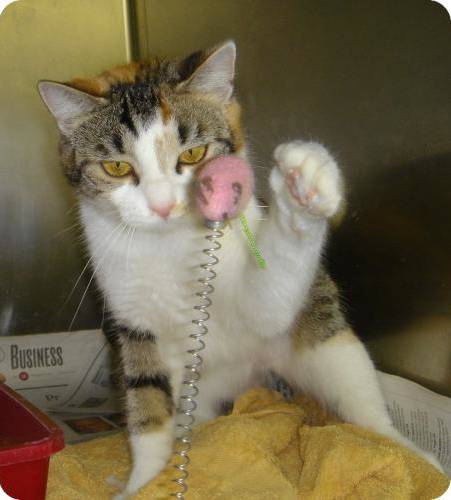

In [5]:
# Display an image
file = '/root/Keras CNN - dogs vs. cats/train/cat/cat.10047.jpg'

img = load_img(file)
print(img.size)  # images have different sizes
img

### Prepare the data generators

To speed up model training, images are being pre-processed:
1. rescaled from 0-255 to 0-1
2. resized to 150x150
3. shuffle the image orders (for training and validation)
4. infer the image label (0: cat, 1: dog) from the directory name

In [6]:
# variables used in this cell
batch_size = 32
img_height = 150
img_width = 150
train_data_dir = '/root/Keras CNN - dogs vs. cats/train'
validation_data_dir= '/root/Keras CNN - dogs vs. cats/validation'
test_data_dir = '/root/Keras CNN - dogs vs. cats/test'


# Construct a training data generator
train_datagen = ImageDataGenerator(rescale=1./255)

# Construct a validation/testing data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Construct a training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

# Construct a validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

# Construct an evaluate generator (same as validation, without shuffle)
evaluate_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False)

# Construct a testing generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [7]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

## Research design

<hr>
For this binary classification problem, we will conduct a 2x2 factorial design to test the effect of image augmentation and dropout layer, measuring the training time (epochs) and performance (cross-entropy loss). Image augmentation is a technique to make the model generalize better by feeding in training images which are transformed (e.g., rotated, shifted, etc.). Dropout is a common regularization technique to avoid overfit. In our models, we will observe the effect of adding the dropout rate at 0.5 (i.e., neurons at that layer have 50% chance of being temporarily 'dropped').


| Experiment | Image augmentation | Dropout |
| --- | --- | ---|
| A | No | No |
| B | No | Yes |
| C | Yes | No |
| D | Yes | Yes |

<hr>

### Experiment A: No image augmentation, no dropout

In [8]:
reset_keras()

# Build the model
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[img_height, img_width, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       5

In [9]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [10]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/CNN_A.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/cats_and_dogs/logs/run_2020_05_21-03_44_24


In [11]:
%%time

# Fit the model
model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, early_stopping_cb])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate for 157 steps
Epoch 1/100
625/625 [==============================] - 211s 337ms/step - loss: 0.6882 - accuracy: 0.5365 - val_loss: 0.6744 - val_accuracy: 0.5956
Epoch 2/100
625/625 [==============================] - 208s 333ms/step - loss: 0.6522 - accuracy: 0.6206 - val_loss: 0.6090 - val_accuracy: 0.6792
Epoch 3/100
625/625 [==============================] - 207s 331ms/step - loss: 0.5866 - accuracy: 0.6902 - val_loss: 0.5506 - val_accuracy: 0.7242
Epoch 4/100
625/625 [==============================] - 208s 333ms/step - loss: 0.5118 - accuracy: 0.7477 - val_loss: 0.4755 - val_accuracy: 0.7658
Epoch 5/100
625/625 [==============================] - 207s 332ms/step - loss: 0.4379 - accuracy: 0.7957 - val_loss: 0.4649 - val_accuracy: 0.7770
Epoch 6/100
625/625 [==============================] - 205s 328ms/step - loss: 0.3604 - accuracy: 0.8403 - val_loss: 0.4233 - val_accuracy: 0.8128
Epoch 7/100
625/625 [==============================] - 207s 331ms/step - l

#### Evaluate

In [12]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/CNN_A.h5')

In [13]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [14]:
# Performance on the validation set
y_pred = model.predict(evaluate_generator)
y_valid = evaluate_generator.classes

print(classification_report(y_valid, np.where(y_pred >= .5, 1, 0), digits=5))

              precision    recall  f1-score   support

           0    0.79985   0.83440   0.81676      2500
           1    0.82692   0.79120   0.80867      2500

    accuracy                        0.81280      5000
   macro avg    0.81338   0.81280   0.81271      5000
weighted avg    0.81338   0.81280   0.81271      5000



#### Predict

In [15]:
# Predict the probability of class 1 (dog)
y_test = model.predict(test_generator)

In [16]:
ids = []

# Generate the image id
for file in test_generator.filenames:
    # Original: unknown/10010.jpg
    file = file.split('/')[1]  # 10010.jpg
    file = file.split('.')[0]  # 10010
    ids.append(file)

# Assemble the submission file
submission = pd.DataFrame({
    'id': ids,
    'label': y_test[:, 0]
})

submission.to_csv('submission_A.csv', index=False)

### Experiment B: Dropouts without image augmentation

In [17]:
reset_keras()

# Build the model
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[img_height, img_width, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       5

In [18]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [19]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/CNN_B.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/cats_and_dogs/logs/run_2020_05_21-04_40_50


In [20]:
%%time

# Fit the model
model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, early_stopping_cb])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate for 157 steps
Epoch 1/100
625/625 [==============================] - 208s 332ms/step - loss: 0.6929 - accuracy: 0.5132 - val_loss: 0.6924 - val_accuracy: 0.5036
Epoch 2/100
625/625 [==============================] - 208s 332ms/step - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
625/625 [==============================] - 209s 334ms/step - loss: 0.6917 - accuracy: 0.5180 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/100
625/625 [==============================] - 209s 334ms/step - loss: 0.6934 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
625/625 [==============================] - 209s 335ms/step - loss: 0.6921 - accuracy: 0.5073 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/100
625/625 [==============================] - 208s 333ms/step - loss: 0.6935 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
625/625 [==============================] - 208s 333ms/step - l

#### Evaluate

In [21]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/CNN_B.h5')

In [22]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [23]:
# Performance on the validation set
y_pred = model.predict(evaluate_generator)
y_valid = evaluate_generator.classes

print(classification_report(y_valid, np.where(y_pred >= .5, 1, 0), digits=5))

              precision    recall  f1-score   support

           0    0.81792   0.78520   0.80122      2500
           1    0.79346   0.82520   0.80902      2500

    accuracy                        0.80520      5000
   macro avg    0.80569   0.80520   0.80512      5000
weighted avg    0.80569   0.80520   0.80512      5000



#### Predict

In [24]:
# Predict the probability of class 1 (dog)
y_test = model.predict(test_generator)

In [25]:
ids = []

# Generate the image id
for file in test_generator.filenames:
    # Original: unknown/10010.jpg
    file = file.split('/')[1]  # 10010.jpg
    file = file.split('.')[0]  # 10010
    ids.append(file)

# Assemble the submission file
submission = pd.DataFrame({
    'id': ids,
    'label': y_test[:, 0]
})

submission.to_csv('submission_B.csv', index=False)

### Data augmentation

In [5]:
# Construct a data generator which does augmentation (e.g., rotate, flip, etc.)
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [27]:
# Augment a sample image
X = img_to_array(img)  # (500, 451, 3)
X = X.reshape((1,) + X.shape)  #(1, 500, 451, 3)

i = 0
for batch in datagen.flow(X, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpg'):
    i += 1
    if i > 10:
        break

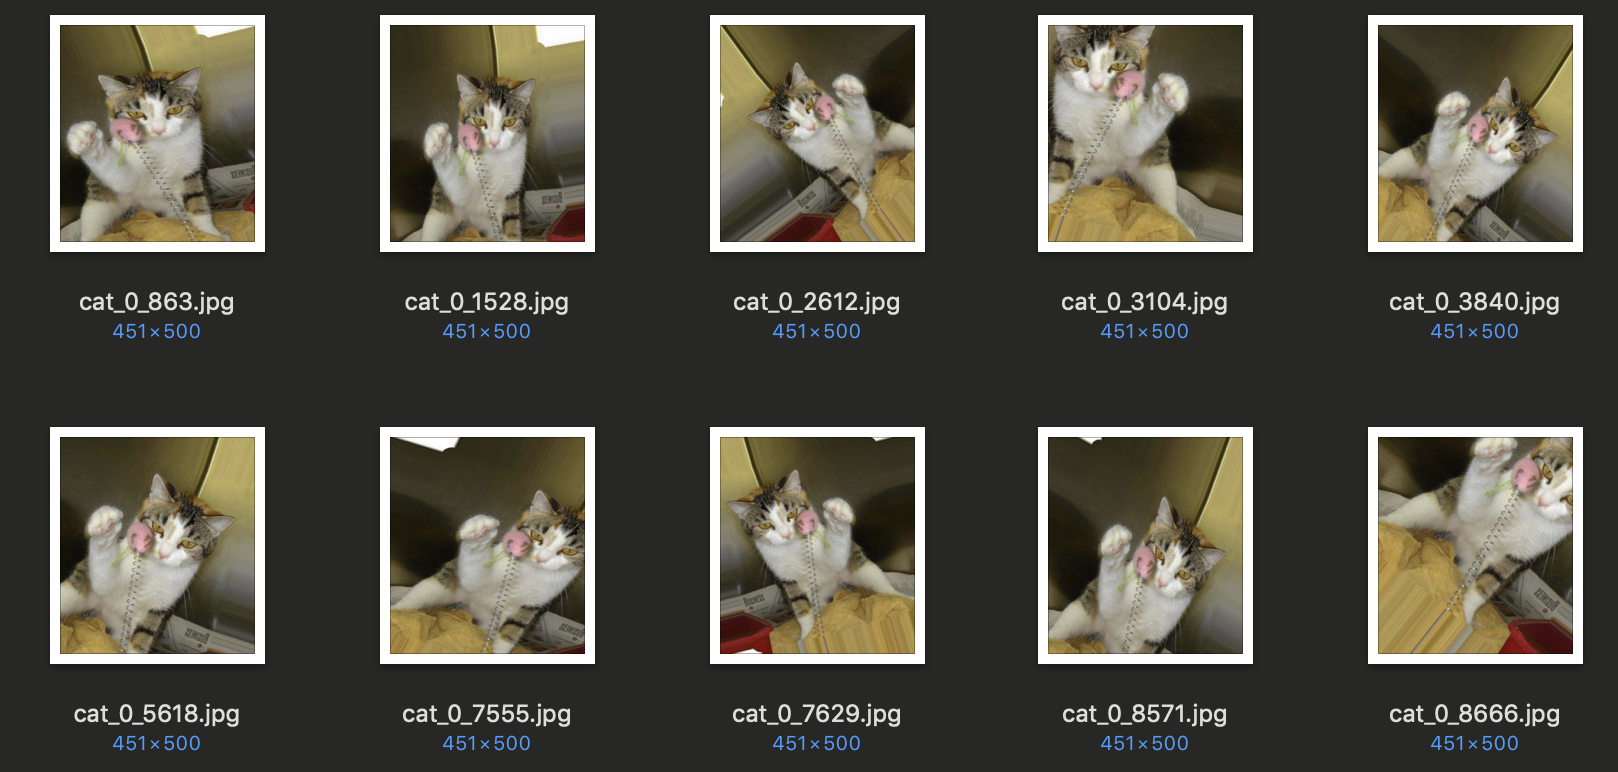

#### Prepare the data generators

In [6]:
# variables used in this cell
batch_size = 32
img_height = 150
img_width = 150
train_data_dir = '/root/Keras CNN - dogs vs. cats/train'
validation_data_dir= '/root/Keras CNN - dogs vs. cats/validation'
test_data_dir = '/root/Keras CNN - dogs vs. cats/test'


# Construct a training data generator with additional rescaling and validation split
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Construct a validation/testing data generator with rescaling only
test_datagen = ImageDataGenerator(rescale=1./255)

# Construct a training generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

# Construct a validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

# Construct an evaluate generator (same as validation, without shuffle)
evaluate_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False)

# Construct a testing generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [29]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

### Experiment C: Image augmentation without dropouts

In [30]:
reset_keras()

# Build the model
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[img_height, img_width, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       5

In [31]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [32]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/CNN_C.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/cats_and_dogs/logs/run_2020_05_21-06_13_43


In [33]:
%%time

# Fit the model
model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, early_stopping_cb])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate for 157 steps
Epoch 1/100
625/625 [==============================] - 283s 452ms/step - loss: 0.6886 - accuracy: 0.5384 - val_loss: 0.6791 - val_accuracy: 0.5996
Epoch 2/100
625/625 [==============================] - 287s 460ms/step - loss: 0.6707 - accuracy: 0.5794 - val_loss: 0.6662 - val_accuracy: 0.5702
Epoch 3/100
625/625 [==============================] - 290s 464ms/step - loss: 0.6516 - accuracy: 0.6188 - val_loss: 0.5976 - val_accuracy: 0.6940
Epoch 4/100
625/625 [==============================] - 289s 462ms/step - loss: 0.6324 - accuracy: 0.6416 - val_loss: 0.5950 - val_accuracy: 0.6628
Epoch 5/100
625/625 [==============================] - 282s 451ms/step - loss: 0.5974 - accuracy: 0.6811 - val_loss: 0.5441 - val_accuracy: 0.7172
Epoch 6/100
625/625 [==============================] - 278s 445ms/step - loss: 0.5697 - accuracy: 0.7026 - val_loss: 0.5020 - val_accuracy: 0.7516
Epoch 7/100
625/625 [==============================] - 277s 443ms/step - l

#### Evaluate

In [34]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/CNN_C.h5')

In [35]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [36]:
# Performance on the validation set
y_pred = model.predict(evaluate_generator)
y_valid = evaluate_generator.classes

print(classification_report(y_valid, np.where(y_pred >= .5, 1, 0), digits=5))

              precision    recall  f1-score   support

           0    0.96719   0.95520   0.96116      2500
           1    0.95575   0.96760   0.96164      2500

    accuracy                        0.96140      5000
   macro avg    0.96147   0.96140   0.96140      5000
weighted avg    0.96147   0.96140   0.96140      5000



#### Predict

In [37]:
# Predict the probability of class 1 (dog)
y_test = model.predict(test_generator)

In [38]:
ids = []

# Generate the image id
for file in test_generator.filenames:
    # Original: unknown/10010.jpg
    file = file.split('/')[1]  # 10010.jpg
    file = file.split('.')[0]  # 10010
    ids.append(file)

# Assemble the submission file
submission = pd.DataFrame({
    'id': ids,
    'label': y_test[:, 0]
})

submission.to_csv('submission_C.csv', index=False)

### Experiment D: Image augmentations and dropouts

In [48]:
reset_keras()

# Build the model
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[img_height, img_width, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       5

In [49]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [50]:
# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/CNN_D.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

s3://tensor.board/cats_and_dogs/logs/run_2020_05_22-00_52_10


In [51]:
%%time

# Fit the model
model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, early_stopping_cb])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate for 157 steps
Epoch 1/200
625/625 [==============================] - 291s 466ms/step - loss: 0.6937 - accuracy: 0.5060 - val_loss: 0.6905 - val_accuracy: 0.5396
Epoch 2/200
625/625 [==============================] - 285s 456ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6913 - val_accuracy: 0.5108
Epoch 3/200
625/625 [==============================] - 282s 451ms/step - loss: 0.6920 - accuracy: 0.5181 - val_loss: 0.6877 - val_accuracy: 0.5678
Epoch 4/200
625/625 [==============================] - 282s 452ms/step - loss: 0.6928 - accuracy: 0.5135 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/200
625/625 [==============================] - 283s 453ms/step - loss: 0.6928 - accuracy: 0.5120 - val_loss: 0.6921 - val_accuracy: 0.5364
Epoch 6/200
625/625 [==============================] - 283s 454ms/step - loss: 0.6911 - accuracy: 0.5272 - val_loss: 0.6971 - val_accuracy: 0.5004
Epoch 7/200
625/625 [==============================] - 288s 461ms/step - l

#### Evaluate

In [52]:
# Load weights of the best fitted
model.load_weights(f'{PATH_CHECKPOINT}/CNN_D.h5')

In [53]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [54]:
# Performance on the validation set
y_pred = model.predict(evaluate_generator)
y_valid = evaluate_generator.classes

print(classification_report(y_valid, np.where(y_pred >= .5, 1, 0), digits=5))

              precision    recall  f1-score   support

           0    0.95022   0.93160   0.94082      2500
           1    0.93291   0.95120   0.94197      2500

    accuracy                        0.94140      5000
   macro avg    0.94157   0.94140   0.94139      5000
weighted avg    0.94157   0.94140   0.94139      5000



#### Predict

In [55]:
# Predict the probability of class 1 (dog)
y_test = model.predict(test_generator)

In [56]:
ids = []

# Generate the image id
for file in test_generator.filenames:
    # Original: unknown/10010.jpg
    file = file.split('/')[1]  # 10010.jpg
    file = file.split('.')[0]  # 10010
    ids.append(file)

# Assemble the submission file
submission = pd.DataFrame({
    'id': ids,
    'label': y_test[:, 0]
})

submission.to_csv('submission_D.csv', index=False)

## Explore some wrongly classified images

Labels are not always correct. It is important to manually check some of the wrongly classified images to a) correct the label, and b) get a sense in what situations the classifier didn't perform well.

In [12]:
# Load the model in experiment C, which has the lowest val_loss among four
model = keras.models.load_model(f'{PATH_CHECKPOINT}/CNN_C.h5')

In [13]:
# Compile the model
optimizer = keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [14]:
# Performance on the validation set
y_pred = model.predict(evaluate_generator)
y_valid = evaluate_generator.classes

In [71]:
def plot_images(idx):
    """
    Find the corresponding files of the idx in the validation set,
    and plot the images.
    """
    fig = plt.figure(figsize=(18, 12))
    
    for i, n in enumerate(idx):
        imgs = load_img(evaluate_generator.filepaths[n])
        
        # Plot
        plot = fig.add_subplot(3, 5, i+1)
        plot.axis('Off')  # no axis
        plot.set_title(y_pred.reshape(-1)[n])
        
        plt.imshow(np.array(imgs))

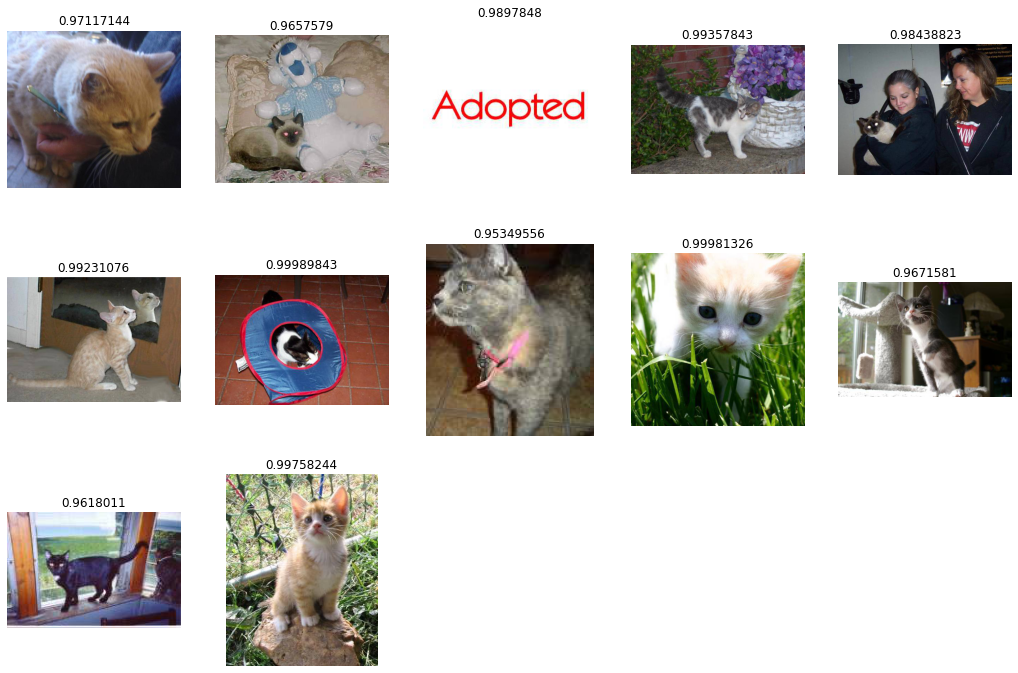

In [73]:
# Indexes of very wrongly classified cats
very_wrong_cats_idx = [i for i, x in enumerate((y_valid == 0) & (y_pred.reshape(-1) >= .95)) if x]
plot_images(very_wrong_cats_idx)

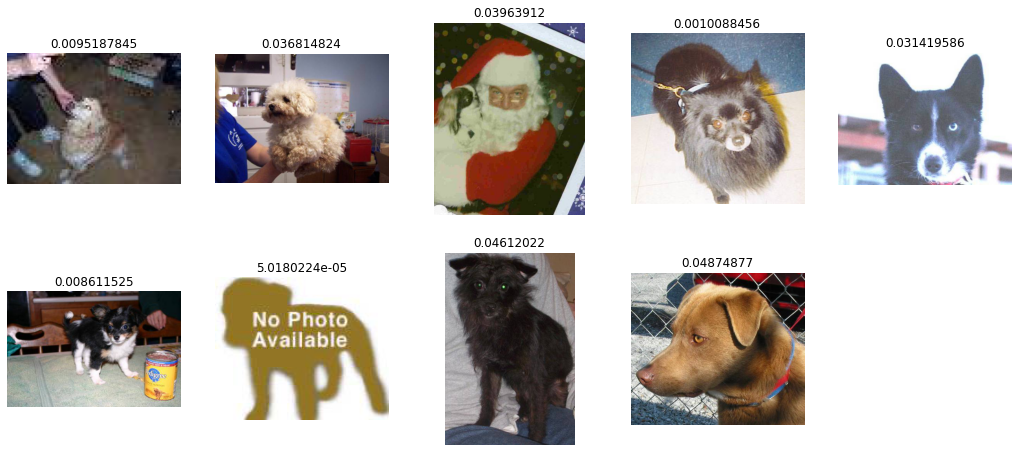

In [74]:
# Indexes of very wrongly classified dogs
very_wrong_dogs_idx = [i for i, x in enumerate((y_valid == 1) & (y_pred.reshape(-1) <= .05)) if x]
plot_images(very_wrong_dogs_idx)

## Conclusion

<hr>

| Experiment | Image augmentation | Dropout | no. of epochs | time per step (ms) | log loss (validation) | log loss (test) |
| --- | --- | --- | --- | --- | --- | --- |
| A | No | No | 6 | 200 | 0.4233 | 0.43414 |
| B | No | Yes | 16 | 210 | 0.4128 | 0.42155 |
| C | Yes | No | 94 | 440 | 0.0990 | 0.18999 |
| D | Yes | Yes | 62 | 450 | 0.1378 | 0.23938 |
| Extra (transfer learning from Xception) | Yes | N/A | 9 | 380 | 0.0406 | 0.11378 |

Models in all four experiments have the same number of parameters (11,741,441). So the differences in fitting time (time per step) and performance (log loss) are mainly due to the effects of image augmentation and dropout layers.

In experiment A we can observe how a model behaves when it goes overfit: training loss keeps decreasing while validation loss first decreases and then increases after a certain epochs. Applying 0.5 dropout rates to the two dense layers (experiment B) does not help much. On the other hand, apply image augmentation (experiment C) has a substantial positive effect. This method forces the model to adapt to "poorly taken images", which in turn generalizes better to unseen images. Adding the dropout layers to experiment D has worsen the performance. One of the reasons may be the regularization is too strong when paired up with the image augmentation.

If we care most the model accuracy and not training time, model in experiment C is the way to go. Another way is to make use of transfer learning of state-of-the-art pretrained model, some of them available on https://keras.io/api/applications/. In the appendix below we have experimented transfer learning with Xception, which is faster to train and have better performance than the CNNs we trained from scratch.

The key is to perform medium-level of image augmentation, including rotatino (40 degree), width & height shifting (0.2), shear (0.2), zoom (0.2) and flipping horizontally. This model works best when the input image is square in size, with the object (cat or dog) centered in the middle.

<hr>

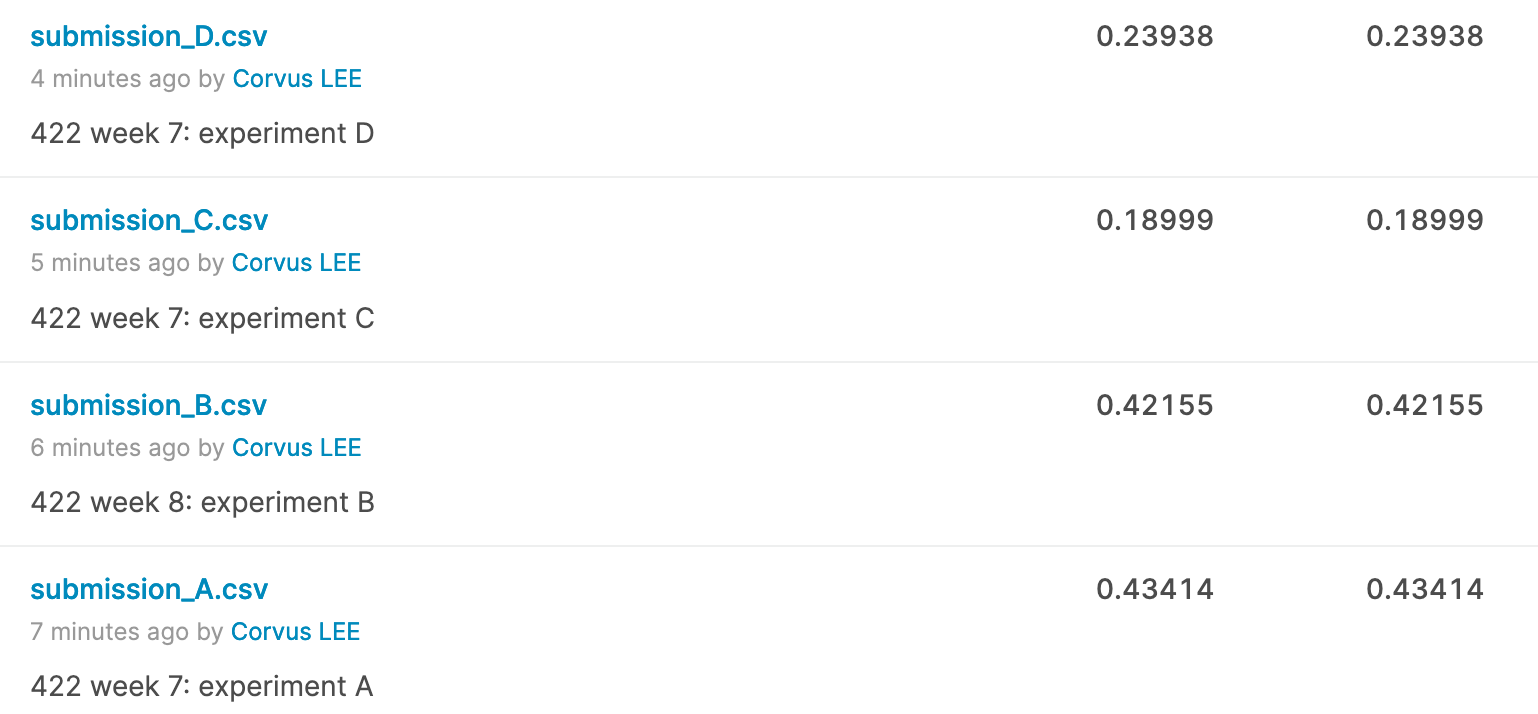

## Appendix: Transfer learning with Xception (pretrained with ImageNet)

The goal is the experiment and get a sense of difference in model fitting time and performance comparing with building a CNN architecture from scratch

In [7]:
# Load the Xception model
base_model = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3),
    pooling='avg'
)

In [8]:
# Add the output layer
output = keras.layers.Dense(1, activation='sigmoid')(base_model.output)

model = keras.Model(
    inputs=base_model.input,
    outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
# Freeze the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Compile and run for a few epochs
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate for 157 steps
Epoch 1/5
625/625 [==============================] - 360s 576ms/step - loss: 0.3965 - accuracy: 0.8386 - val_loss: 0.1725 - val_accuracy: 0.9580
Epoch 2/5
625/625 [==============================] - 222s 356ms/step - loss: 0.3225 - accuracy: 0.8625 - val_loss: 0.1362 - val_accuracy: 0.9640
Epoch 3/5
625/625 [==============================] - 221s 353ms/step - loss: 0.2971 - accuracy: 0.8704 - val_loss: 0.1958 - val_accuracy: 0.9484
Epoch 4/5
625/625 [==============================] - 221s 354ms/step - loss: 0.2912 - accuracy: 0.8720 - val_loss: 0.1262 - val_accuracy: 0.9646
Epoch 5/5
625/625 [==============================] - 224s 358ms/step - loss: 0.2865 - accuracy: 0.8726 - val_loss: 0.1314 - val_accuracy: 0.9636


In [11]:
## Unfreeze the whole model
for layer in base_model.layers:
    layer.trainable = True

In [14]:
# Compile and train with a smaller learning rate
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacks
logdir = get_logdir()
print(logdir)

checkpoint_cb = keras.callbacks.ModelCheckpoint(f'{PATH_CHECKPOINT}/xception.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(logdir, update_freq='epoch')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, early_stopping_cb])

s3://tensor.board/cats_and_dogs/logs/run_2020_05_24-14_23_39
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 625 steps, validate for 157 steps
Epoch 1/100
625/625 [==============================] - 240s 384ms/step - loss: 0.1539 - accuracy: 0.9387 - val_loss: 0.0547 - val_accuracy: 0.9804
Epoch 2/100
625/625 [==============================] - 238s 381ms/step - loss: 0.0734 - accuracy: 0.9721 - val_loss: 0.0444 - val_accuracy: 0.9838
Epoch 3/100
625/625 [==============================] - 240s 383ms/step - loss: 0.0567 - accuracy: 0.9780 - val_loss: 0.0424 - val_accuracy: 0.9860
Epoch 4/100
625/625 [==============================] - 238s 380ms/step - loss: 0.0408 - accuracy: 0.9850 - val_loss: 0.0406 - val_accuracy: 0.9880
Epoch 5/100
625/625 [==============================] - 235s 376ms/step - loss: 0.0357 - accuracy: 0.9865 - val_loss: 0.0410 - val_accuracy: 0.9880
Epoch 6/100
625/625 [==============================] - 244s 390ms/step - loss: 0.0307 - accuracy: 0.9887 - val_loss: 0.0458 - val_accuracy: 0.9856
Epoch 7/100
625/625 [==============================] - 260s 417ms/step - l

In [15]:
# Performance on the validation set
y_pred = model.predict(evaluate_generator)
y_valid = evaluate_generator.classes

print(classification_report(y_valid, np.where(y_pred >= .5, 1, 0), digits=5))

              precision    recall  f1-score   support

           0    0.98917   0.98680   0.98799      2500
           1    0.98683   0.98920   0.98801      2500

    accuracy                        0.98800      5000
   macro avg    0.98800   0.98800   0.98800      5000
weighted avg    0.98800   0.98800   0.98800      5000



In [16]:
# Predict the probability of class 1 (dog)
y_test = model.predict(test_generator)

In [17]:
ids = []

# Generate the image id
for file in test_generator.filenames:
    # Original: unknown/10010.jpg
    file = file.split('/')[1]  # 10010.jpg
    file = file.split('.')[0]  # 10010
    ids.append(file)

# Assemble the submission file
submission = pd.DataFrame({
    'id': ids,
    'label': y_test[:, 0]
})

submission.to_csv('submission_xception.csv', index=False)

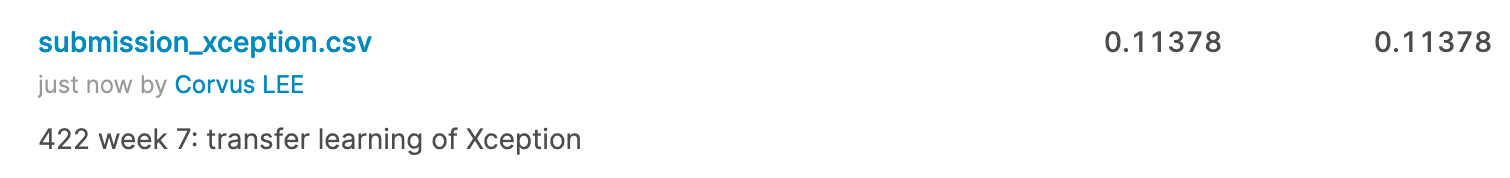